In [1]:
from yellowcab import io, model
from yellowcab.io.output import save_model
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Load and enrich data

In [2]:
df_raw = io.read_all_files('parquet')

In [3]:
%%time
df_raw = io.add_weather_data(df_raw)
df_raw = io.add_lockdown(df_raw)

Wall time: 39 s


# Feature Selection

In [4]:
# df_raw = df_raw.sample(100000)

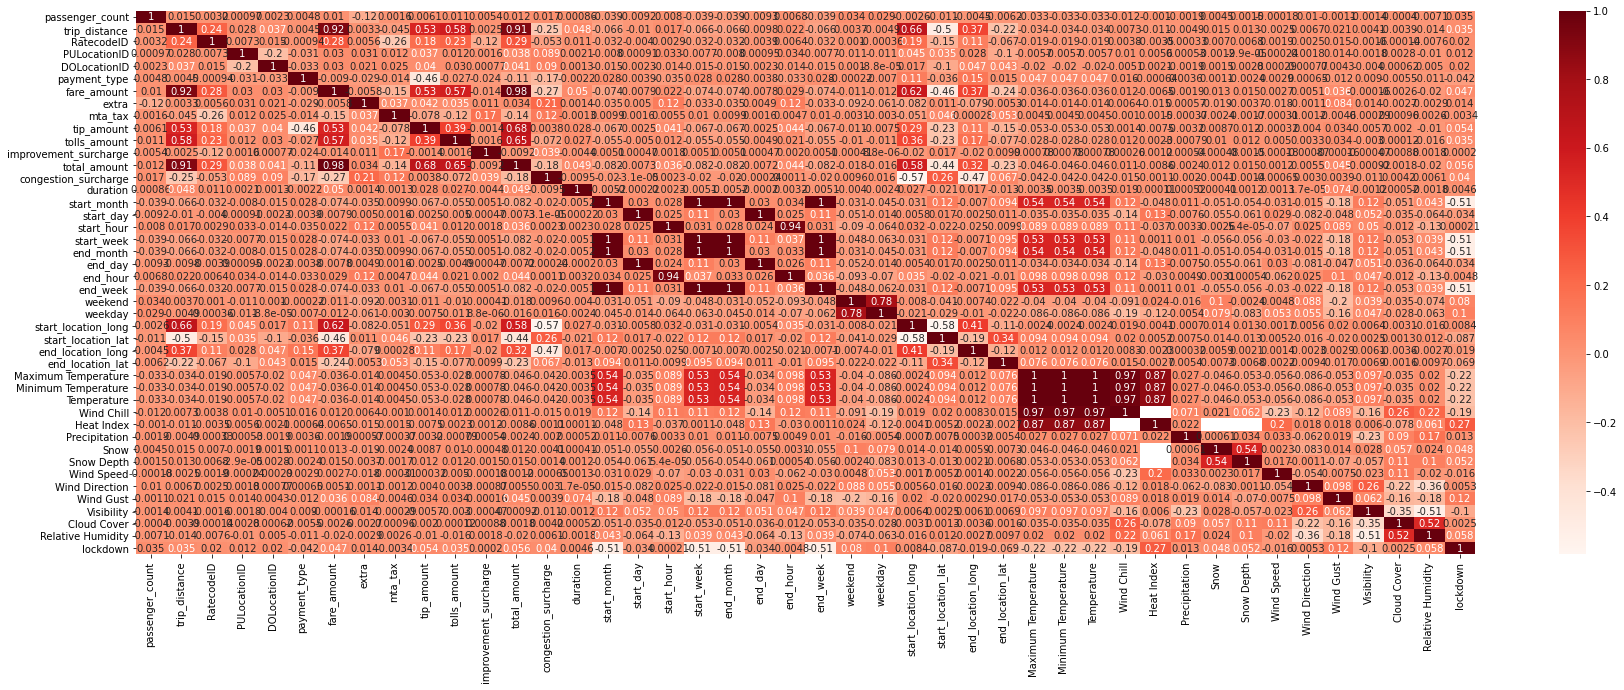

Relevant features:
payment_type            1.000000
tip_amount              0.456819
congestion_surcharge    0.173473
end_location_long       0.147303
start_location_long     0.114437
total_amount            0.108109
Temperature             0.046932
Minimum Temperature     0.046932
Maximum Temperature     0.046932
lockdown                0.041719
Name: payment_type, dtype: float64


In [5]:
def correlation_analysis(trip_data, drop_columns, dep_var, figname):

    #dropping unnecessary columns
    trip_data_filtered = trip_data.drop(columns = drop_columns)

    #Using Pearson Correlation feature selection heatmap for numeric input and numeric output
    fig = plt.figure(figsize=(30,10))
    cor = trip_data_filtered.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    io.save_fig(fig, figname)
    plt.show()

    #Correlation with output variable
    cor_target = abs(cor[dep_var])

    relevant_features = cor_target.sort_values(ascending=False)[abs(cor_target)>0.04]
    print("Relevant features:")
    print(relevant_features)

correlation_analysis(df_raw, [], 'payment_type', 'features_payment' )

## Selected Features
### are above 0.4, Location IDs instead of longitudes for more Information, Temperature for all temp features

In [4]:
X = df_raw[['tip_amount',
             'congestion_surcharge',
             'DOLocationID',
             'PULocationID',
             'total_amount',
             'Temperature',
             'lockdown']]
y = df_raw[['payment_type']].astype(int)

### Occurences of payment_types

In [7]:
y.groupby(['payment_type']).size()

payment_type
1    5366464
2    1962931
3      34886
4      12626
dtype: int64

# Preprocessing Pipeline

In [5]:
numeric_features = ['tip_amount', 'congestion_surcharge', 'total_amount', 'Temperature', 'lockdown']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['DOLocationID', 'PULocationID']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Train-test-split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
y_train = y_train.to_numpy().ravel()

## Logistic Regression

In [10]:
%%time
log_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(random_state=123,
                                                              max_iter=10,
                                                              verbose=1,
                                                              n_jobs=-1))])
log_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.0min finished


Wall time: 1min 13s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['tip_amount',
                                                   'congestion_surcharge',
                                                   'total_amount',
                                                   'Temperature', 'lockdown']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DOLocationID',
                                                   'PULocationID']

In [11]:
%%time
p_test = log_model.predict(X_test)
print(classification_report(y_test, p_test))

d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      0.95      0.97   1072423
           2       0.86      1.00      0.92    393297
           3       0.00      0.00      0.00      7115
           4       0.00      0.00      0.00      2547

    accuracy                           0.96   1475382
   macro avg       0.46      0.49      0.47   1475382
weighted avg       0.96      0.96      0.95   1475382

Wall time: 3.75 s


d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## K-Nearest Neighbor

In [12]:
%%time
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier(n_neighbors=4,
                                                                n_jobs=-1))])
knn_model.fit(X_train, y_train)

Wall time: 13.2 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['tip_amount',
                                                   'congestion_surcharge',
                                                   'total_amount',
                                                   'Temperature', 'lockdown']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DOLocationID',
                                                   'PULocationID']

#### KNN prediction ignored because of immense runtime

In [ ]:
%%time
# p_test = knn_model.predict(X_test)
# print(classification_report(y_test, p_test))

## Decision Tree

In [14]:
%%time
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier(random_state=123,
                                                                  max_depth=10))])
dt_model.fit(X_train, y_train)

Wall time: 1min 34s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['tip_amount',
                                                   'congestion_surcharge',
                                                   'total_amount',
                                                   'Temperature', 'lockdown']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DOLocationID',
                                                   'PULocationID']

In [15]:
%%time
p_test = dt_model.predict(X_test)
print(classification_report(y_test, p_test))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98   1072423
           2       0.89      0.99      0.94    393297
           3       0.53      0.01      0.02      7115
           4       0.20      0.00      0.00      2547

    accuracy                           0.97   1475382
   macro avg       0.65      0.49      0.49   1475382
weighted avg       0.97      0.97      0.96   1475382

Wall time: 3.91 s


## Random Forest

In [16]:
%%time
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(random_state=123,
                                                                  n_jobs=-1,
                                                                  verbose=1,
                                                                  n_estimators=200,
                                                                  max_depth=100
                                                                  ))])
rf_model.fit(X_train, y_train)
save_model('payment_type_rf', rf_model)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 60.8min finished


Wall time: 1h 1min 6s


In [17]:
%%time
p_test = rf_model.predict(X_test)
print(classification_report(y_test, p_test))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    4.8s finished


              precision    recall  f1-score   support

           1       1.00      0.96      0.98   1072423
           2       0.89      1.00      0.94    393297
           3       0.39      0.01      0.02      7115
           4       0.36      0.00      0.01      2547

    accuracy                           0.97   1475382
   macro avg       0.66      0.49      0.49   1475382
weighted avg       0.97      0.97      0.96   1475382

Wall time: 8.62 s


## Support Vector Machine

In [18]:
%%time
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(random_state=123,
                                               max_iter=1000))])
svm_model.fit(X_train, y_train)

Wall time: 55min 1s


d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['tip_amount',
                                                   'congestion_surcharge',
                                                   'total_amount',
                                                   'Temperature', 'lockdown']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DOLocationID',
                                                   'PULocationID']

In [19]:
%%time
p_test = svm_model.predict(X_test)
print(classification_report(y_test, p_test))

d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.83      0.62      0.71   1072423
           2       0.41      0.17      0.24    393297
           3       0.01      0.38      0.01      7115
           4       0.00      0.00      0.00      2547

    accuracy                           0.50   1475382
   macro avg       0.31      0.29      0.24   1475382
weighted avg       0.71      0.50      0.58   1475382

Wall time: 13min 22s


d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multi-Layer Perceptron

In [9]:
%%time
nn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier(random_state=123,
                                                         hidden_layer_sizes=(150,150,150),
                                                         verbose=1,
                                                         max_iter=20,
                                                         early_stopping=True,
                                                         n_iter_no_change=3,
                                                         tol=1e-3,
                                                         learning_rate='adaptive',
                                                         solver='sgd'))])

nn_model.fit(X_train, y_train)
save_model('payment_type_nn', nn_model)

Iteration 1, loss = 0.14615312
Validation score: 0.962627
Iteration 2, loss = 0.12990151
Validation score: 0.962627
Iteration 3, loss = 0.12905534
Validation score: 0.963340
Iteration 4, loss = 0.12858251
Validation score: 0.963128
Iteration 5, loss = 0.12826448
Validation score: 0.963409
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Setting learning rate to 0.000200
Iteration 6, loss = 0.12748707
Validation score: 0.963570
Iteration 7, loss = 0.12738304
Validation score: 0.963633
Iteration 8, loss = 0.12732377
Validation score: 0.963606
Iteration 9, loss = 0.12724363
Validation score: 0.963618
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Setting learning rate to 0.000040
Iteration 10, loss = 0.12703479
Validation score: 0.963626
Iteration 11, loss = 0.12701260
Validation score: 0.963665
Iteration 12, loss = 0.12699172
Validation score: 0.963621
Iteration 13, loss = 0.12697552
Validation score: 0.963677
Validation

d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [11]:
%%time
p_test = nn_model.predict(X_test)
print(classification_report(y_test, p_test))

d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      0.96      0.98   1072423
           2       0.89      0.99      0.94    393297
           3       0.00      0.00      0.00      7115
           4       0.00      0.00      0.00      2547

    accuracy                           0.96   1475382
   macro avg       0.47      0.49      0.48   1475382
weighted avg       0.96      0.96      0.96   1475382

Wall time: 16.1 s


d:\onedrive - universität zu köln\uni\pds\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
